Hello! Welcome to my notebook for the Multi-Class Prediction of Obesity Risk. At the time of writing, this submission placed me 167th (top 10% 🎉) on the public leaderboard. I've tried to document my steps thoroughly so its relatively easy to follow. I hope you find it helpful and comments welcome!

**(If you do find it helpful. Please upvote so that it's easier for others to find. Thank you! 🙏)**

<a id = "table-of-contents"></a>
# Table of Contents

- [Import Data and Inital Review](#intro)
    - [Import data](#import)
    - [Separate target and test/ train features](#testtrain)
- [EDA](#EDA)
    - [What is the target?](#what-target)
    - [What are the features?](#what-features)
    - [Exploring the target](#target)
    - [Exploring categorical features](#cat-features)
    - [Exploring numerical features](#num-features)
    - [Feature distributions by target category](#features-by-target)
    - [Exploring the competition training set versus the original dataset](#comp-original)
- [Pre-processing](#pre-processing)
    - [Missing data](#missing)
    - [Encoding target labels](#encode-target)
    - [Encoding category features](#encode-cats)
    - [Feature importances](#importances)
- [Modelling](#modelling)
    - [XGBoost](#xgb)
    - [CatBoost](#cb)
    - [LightGBM](#lgbm)
    - [Voting Classifier](#vote)
- [Predictions](#pred)
    - [Final pre-processing pipeline](#final)
    - [Predictions on test set](#test)
- [Submission](#sub)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import randint, uniform, loguniform

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, RandomizedSearchCV,\
LearningCurveDisplay
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

# Import data and inital review

We'll start by downloading the training test datasets and making some initiatial observations on the data in its raw form. Whilst we're at it, we'll download the original dataset as well (i.e. the real dataset that the dummy compeition dataset was based on.)

<a id = "import"></a>
### Import data

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col='id')
train_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
examples, columns = train_df.shape
print(f'The training dataset contains:\n{examples:,} examples\n{columns - 1} features\n1 target column "NObeyesdad"')

The training dataset contains:
20,758 examples
16 features
1 target column "NObeyesdad"


In [5]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col='id')
test_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [6]:
examples, columns = test_df.shape
print(f'The test dataset contains:\n{examples:,} examples\n{columns} features')

The test dataset contains:
13,840 examples
16 features


In [7]:
orig_df = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')
orig_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [8]:
examples, columns = orig_df.shape
print(f'The original dataset contains:\n{examples:,} examples\n{columns - 1} features\n1 target column "NObeyesdad"')

The original dataset contains:
2,111 examples
16 features
1 target column "NObeyesdad"


It will come in handy later, in the Exploratory Data Analysis (EDA), to combine the training set with the original dataset (`train_combined_df`) and the training set with the test set (`X_train_test`).

In [9]:
train_combined_df = pd.concat([train_df, orig_df], keys=['competition', 'original'],) # concatenate with keys so we can distinguish the source.
train_combined_df['Set'] = train_combined_df.index.get_level_values(0) # create a column from the keys.
train_combined_df = train_combined_df.droplevel(0) # remove the keys.
train_combined_df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Set
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,competition
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,competition
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,competition
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,competition
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,competition
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.000000,3.000000,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III,original
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.000000,3.000000,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III,original
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.000000,3.000000,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III,original
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.000000,3.000000,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III,original


In [10]:
X_train_test = pd.concat([train_df.drop(columns='NObeyesdad'), test_df], keys=['train', 'test'],)
X_train_test['Set'] = X_train_test.index.get_level_values(0)
X_train_test = X_train_test.droplevel(0)
X_train_test

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Set
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,train
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,train
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,train
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,train
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34593,Male,23.327836,1.721384,78.030383,yes,no,2.813234,3.000000,Sometimes,no,1.000000,no,0.807076,0.778632,Sometimes,Public_Transportation,test
34594,Female,29.000000,1.590000,62.000000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,test
34595,Female,22.935612,1.585547,44.376637,no,yes,3.000000,2.273740,Frequently,no,2.000000,no,1.949840,1.000000,Sometimes,Public_Transportation,test


<a id = "testtrain"></a>
### Separate target and test/ train features

When it comes to training the models, we'll need the target variable and feature variables in separate DataFrames, so we'll do that now too.

In [11]:
X_train_raw = train_df.drop(columns='NObeyesdad')
X_train_raw.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation


In [12]:
X_train_comb = train_combined_df.drop(columns=['NObeyesdad', 'Set'])
X_train_comb.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation


In [13]:
X_test_raw = test_df # Just for naming consistency.


In [14]:
X_train_raw.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

From the cell outputs above, we can see that we have some numerical columns (object) and some numerical columns (float64). It will be useful to access these by name. So let's create lists of each.

In [15]:
num_features = X_train_raw.select_dtypes(include='float64').columns.to_list()
cat_features = X_train_raw.select_dtypes(include='object').columns.to_list()

In [16]:
X_train_raw[cat_features].describe()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
count,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
freq,10422,17014,18982,17529,20513,20071,15066,16687


In [17]:
X_test_raw[cat_features].describe()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
count,13840,13840,13840,13840,13840,13840,13840,13840
unique,2,2,2,4,2,2,4,5
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
freq,6965,11384,12583,11689,13660,13376,9979,11111


The `descibe` method for train and test datasets look roughly similar. Note that CALC have only 3 unique categories in the training set but has 4 in the test set. Let's separate out the binary (yes/no) features and the categorical variables that are based on frequency (no, sometimes, frequently, always) as we'll treat these differently in our pre-processing pipeline.

In [18]:
freq_features = ['CAEC', 'CALC']
binary_features = [item for item in cat_features if item not in freq_features]

print(f'Categorical features are:\n{cat_features}\n')
print(f'Frequency based categorical features are:\n{freq_features}\n')
print(f'Binary (yes/no) features are:\n{binary_features}\n')
print(f'Numerical features are:\n{num_features}')

Categorical features are:
['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

Frequency based categorical features are:
['CAEC', 'CALC']

Binary (yes/no) features are:
['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

Numerical features are:
['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


In [19]:
# Assign columns as dtype category for faster processing when using Catboost.
X_train_comb[cat_features] = X_train_comb[cat_features].astype('category')
X_train_raw[cat_features] = X_train_raw[cat_features].astype('category')
X_test_raw[cat_features] = X_train_raw[cat_features].astype('category')

Finally, let's make sure we have associated target variables for the training set and combined (train/original) set.

In [20]:
y_train_raw = train_df['NObeyesdad']
y_train_raw

id
0        Overweight_Level_II
1              Normal_Weight
2        Insufficient_Weight
3           Obesity_Type_III
4        Overweight_Level_II
                ...         
20753        Obesity_Type_II
20754    Insufficient_Weight
20755        Obesity_Type_II
20756    Overweight_Level_II
20757        Obesity_Type_II
Name: NObeyesdad, Length: 20758, dtype: object

In [21]:
y_train_comb = train_combined_df['NObeyesdad']
y_train_comb

0       Overweight_Level_II
1             Normal_Weight
2       Insufficient_Weight
3          Obesity_Type_III
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 22869, dtype: object

# EDA

Now let's get into a more detailed review. What does the data we have actually mean?

<a id = "what-target"></a>
### What is the target?

The target is the level of obesity, which is separated into 6 categories.
- **Insufficient_Weight**
- **Normal_Weight**
- **Overweight_Level_I**
- **Overweight_Level_II**
- **Obesity_Type_I**
- **Obesity_Type_II**
- **Obesity_Type_III**

<a id = "what-features"></a>
### What are the features?

Summary of the 16 features in alphabetical order.
- **Age** - Age of person
- **CAEC** - Consumption of food between meals
- **CALC** - Consumption of alcohol
- **CH20** - Consumption of water daily
- **FAF** - Physical activity frequency
- **FAVC** - Frequent consumption of high caloric food
- **FCVC** - Frequency of consumption of vegetables
- **Gender** - Gender of person
- **Height** - Height of person
- **MTRANS** - Transportation used
- **NCP** - Number of main meals
- **SCC** - Calories consumption monitoring
- **SMOKE** - Whether person smokes
- **TUE** - Time using technology devices
- **Weight** - Weight of the person
- **family_history_with_overweight** - Whether there is a family history of overweight people



<a id = "target"></a>
### Exploring the target

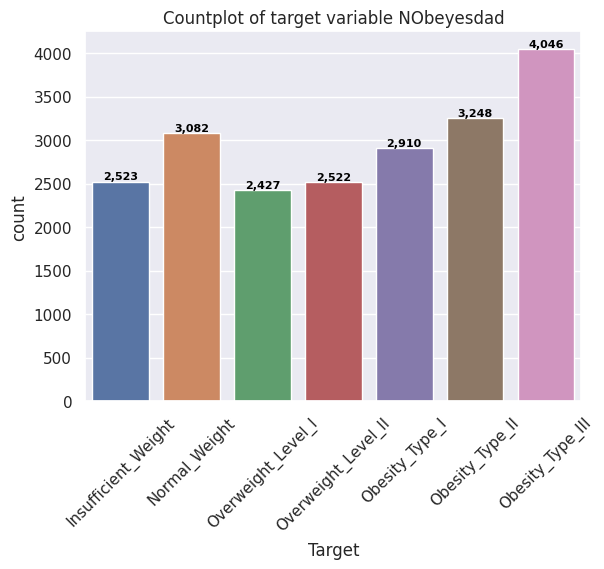

In [22]:
target_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
ax = sns.countplot(x=y_train_raw, order=target_order)
ax.tick_params(axis='x', rotation=45)
ax.bar_label(ax.containers[0], fmt='{:,.0f}', label_type='edge', fontsize=8, color='black', weight='bold')
ax.set_xlabel('Target', labelpad=5)
ax.set_title('Countplot of target variable NObeyesdad')
ax;

💡 Insight from target countplot:
- Examples in each category range from approximately 2,500 to 4,000
- Highest categories are Obesity Type III, Obesity Type II and Normal Weight.

<a id = "cat-features"></a>
### Exploring categorical features

Let's look at the distributions of the categorical variables for both the train and test sets.

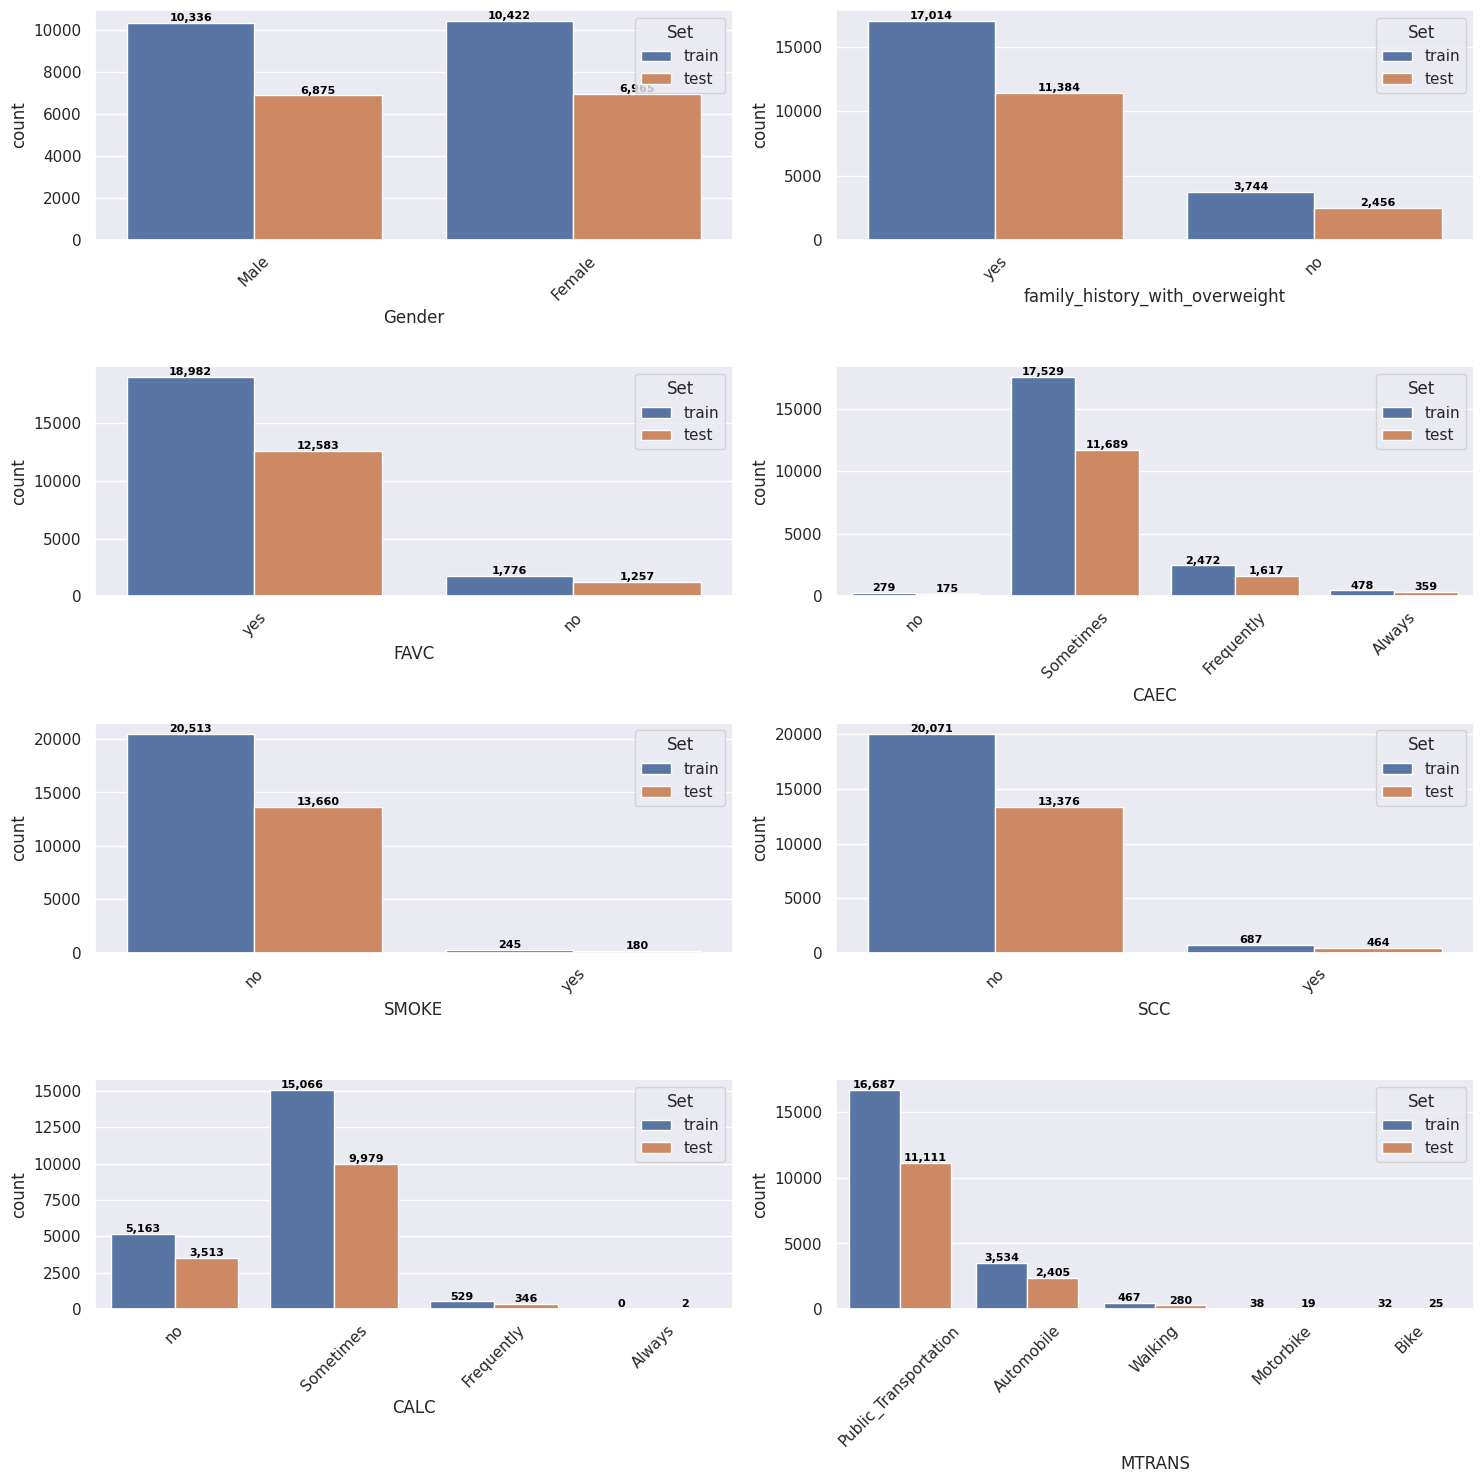

In [23]:
num_cols = len(X_train_test[cat_features].columns)

ncols = 2 # plot in two columns
nrows = math.ceil(num_cols / ncols) # determine number of rows

# Set plot size and create a grid of subplots.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for i, col in enumerate(X_train_test[cat_features].columns):
    # Assign subplot to grid spaces.
    row_idx = i // ncols
    col_idx = i % ncols

    # Set order when categories are more than 2,
    if col in ['CAEC', 'CALC']:
        order=['no', 'Sometimes', 'Frequently', 'Always']
    else:
        order=None

    ax = sns.countplot(x=col, data=X_train_test, ax=axes[row_idx, col_idx], hue='Set', order=order)

    # Rotate x-axis labels and tick parameters for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.bar_label(ax.containers[0], fmt='{:,.0f}', label_type='edge', fontsize=8, color='black', weight='bold')
    ax.bar_label(ax.containers[1], fmt='{:,.0f}', label_type='edge', fontsize=8, color='black', weight='bold')

plt.tight_layout()
plt.show()

💡 Insight from countplots:
- Roughly even split between men and women.
- Majority of people in the dataset have family history of being overweight.
- Majority eat high calorific foods.
- Majority is food at least sometimes between meals.
- Majority are non-smokers.
- Majority don't monitor their calorie intake.
- Majority are consuming alcohol 'sometimes' or 'frequently'
- Majority take public transport, some drive and few walk, bike or motorbike.
- Distributions of test and train look roughly similar across categories.

<a id = "num-features"></a>
### Exploring numerical features

Now we'll do the same for the numerical features.

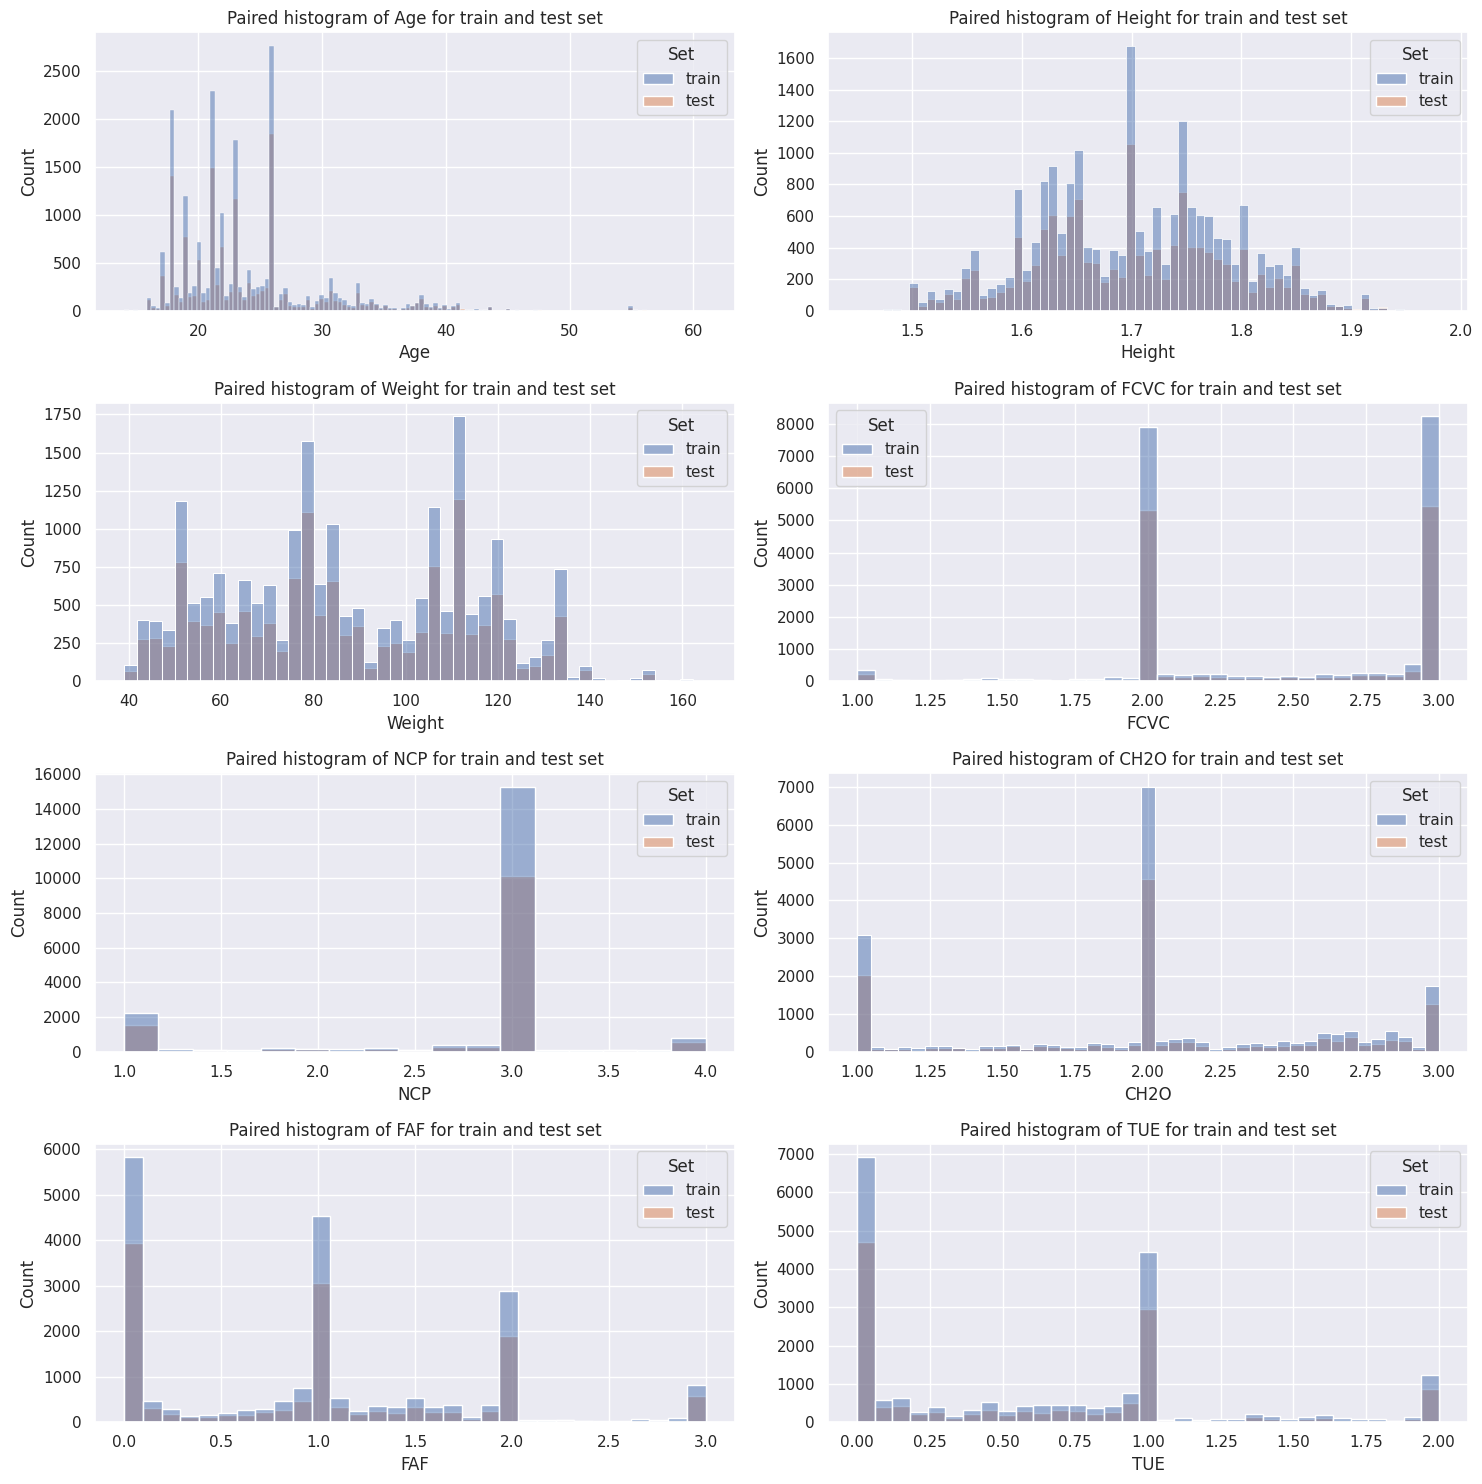

In [24]:
num_cols = len(X_train_test[cat_features].columns)

ncols = 2
nrows = math.ceil(num_cols / ncols) # determine number of rows for subplots

# Set plot size and create a grid of subplots.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for i, col in enumerate(X_train_test[num_features].columns):
    # Assign subplot to grid spaces.
    row_idx = i // ncols
    col_idx = i % ncols

    ax = sns.histplot(x=col, data=X_train_test, ax=axes[row_idx, col_idx], hue='Set',)
    ax.set(title=f"Paired histogram of {col} for train and test set")

plt.tight_layout()
plt.show()

Insight from histograms:
- Height, weight and age have relatives smooth distributions.
- Other numerical variables spike at integer values, so may behave like categorical variables.

Let's see if we learn anything different from the same information as boxplots.

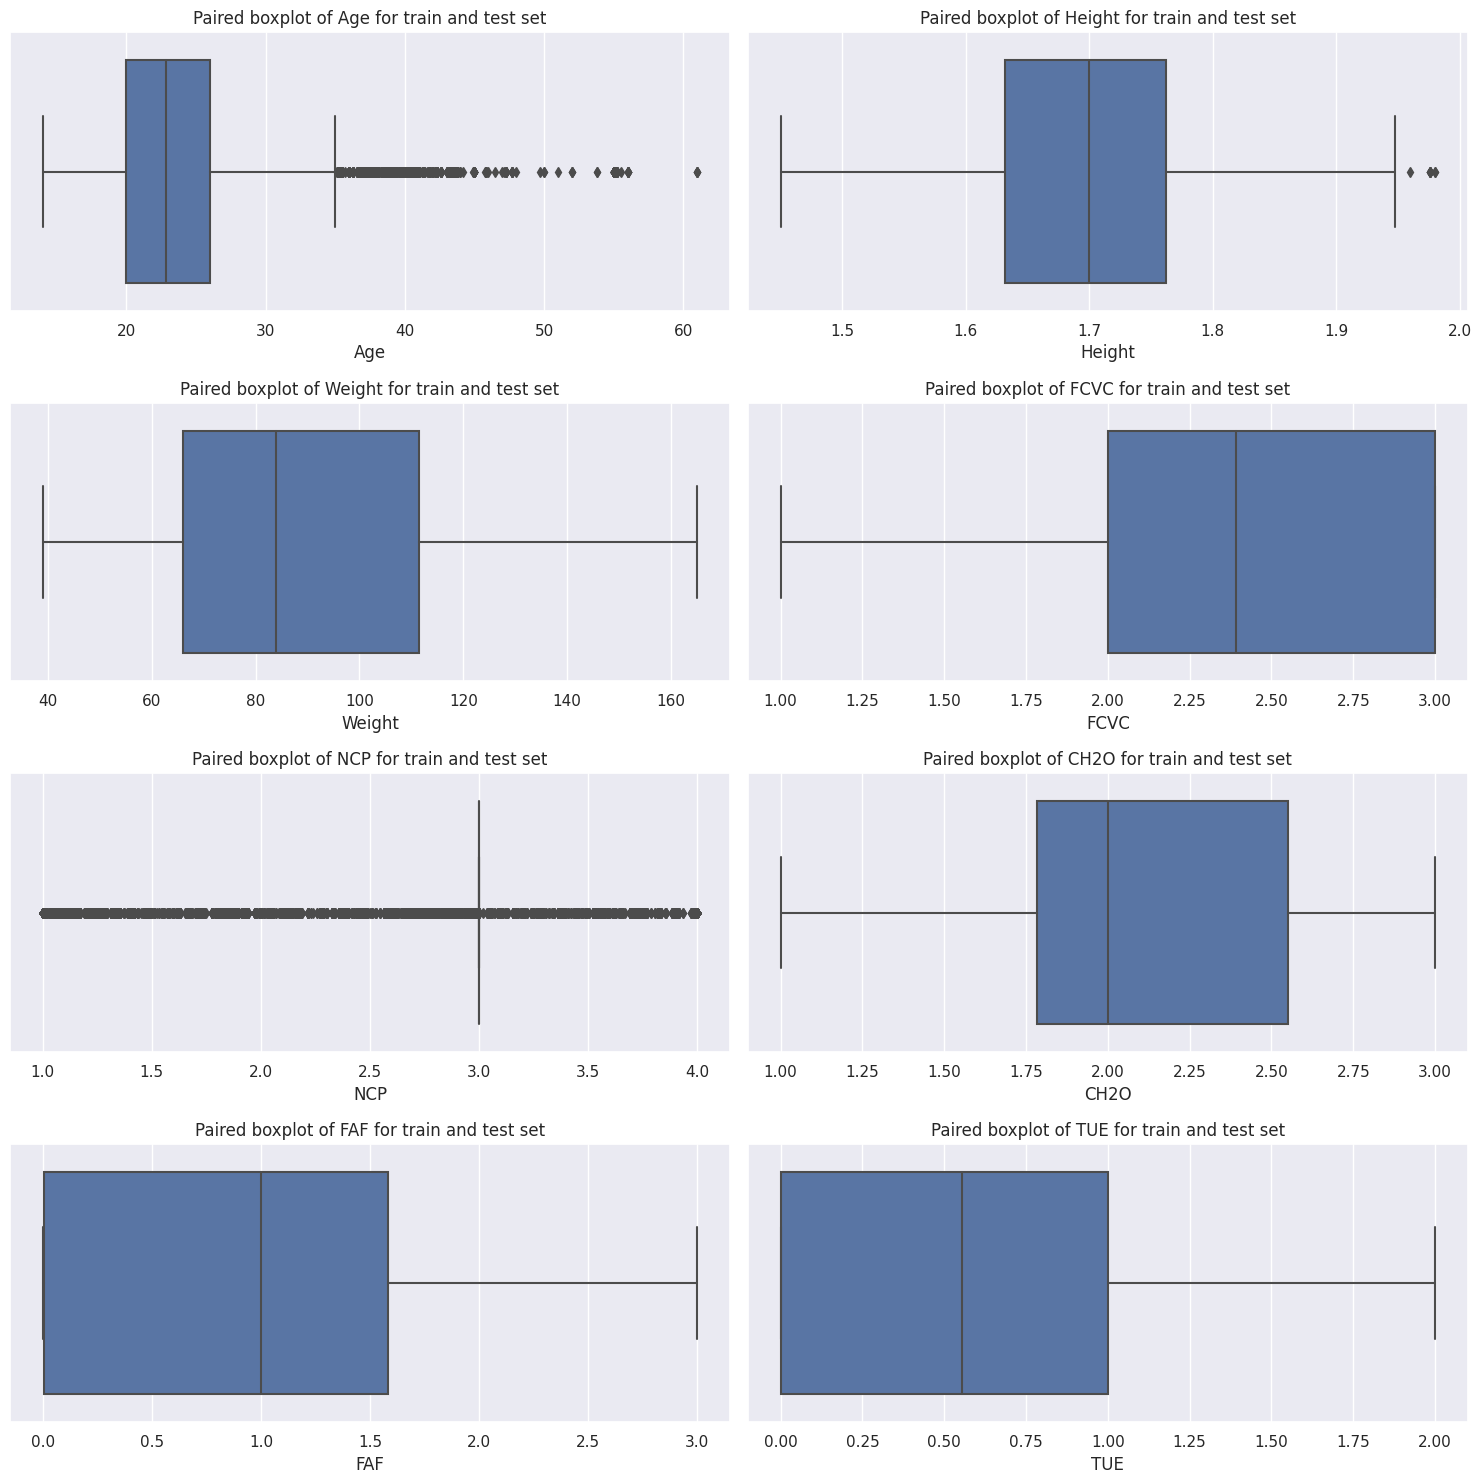

In [25]:
num_cols = len(X_train_test[cat_features].columns)

ncols = 2
nrows = math.ceil(num_cols / ncols) # determine number of rows for subplots

# Set plot size and create a grid of subplots.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for i, col in enumerate(X_train_test[num_features].columns):
    # Assign subplot to grid spaces.
    row_idx = i // ncols
    col_idx = i % ncols

    ax = sns.boxplot(x=col, data=X_train_test, ax=axes[row_idx, col_idx], hue='Set',)
    ax.set(title=f"Paired boxplot of {col} for train and test set")

plt.tight_layout()
plt.show()

💡 Insight from boxplots plots:
- Train and test distributions are similar.
- Age is centered around mid-20s with outliers from above about 35 yrs old.
- Number of meals (NCP) heavily centered on 3.
- Other numerical variables spike at integer values, so may behave like categorical variables.

<a id = "features-by-cat"></a>
### Feature distributions by target category

Let's examine how the feature distributions vary by target. This may give us a clue as to which features are most important.

#### Numerical features by target category 

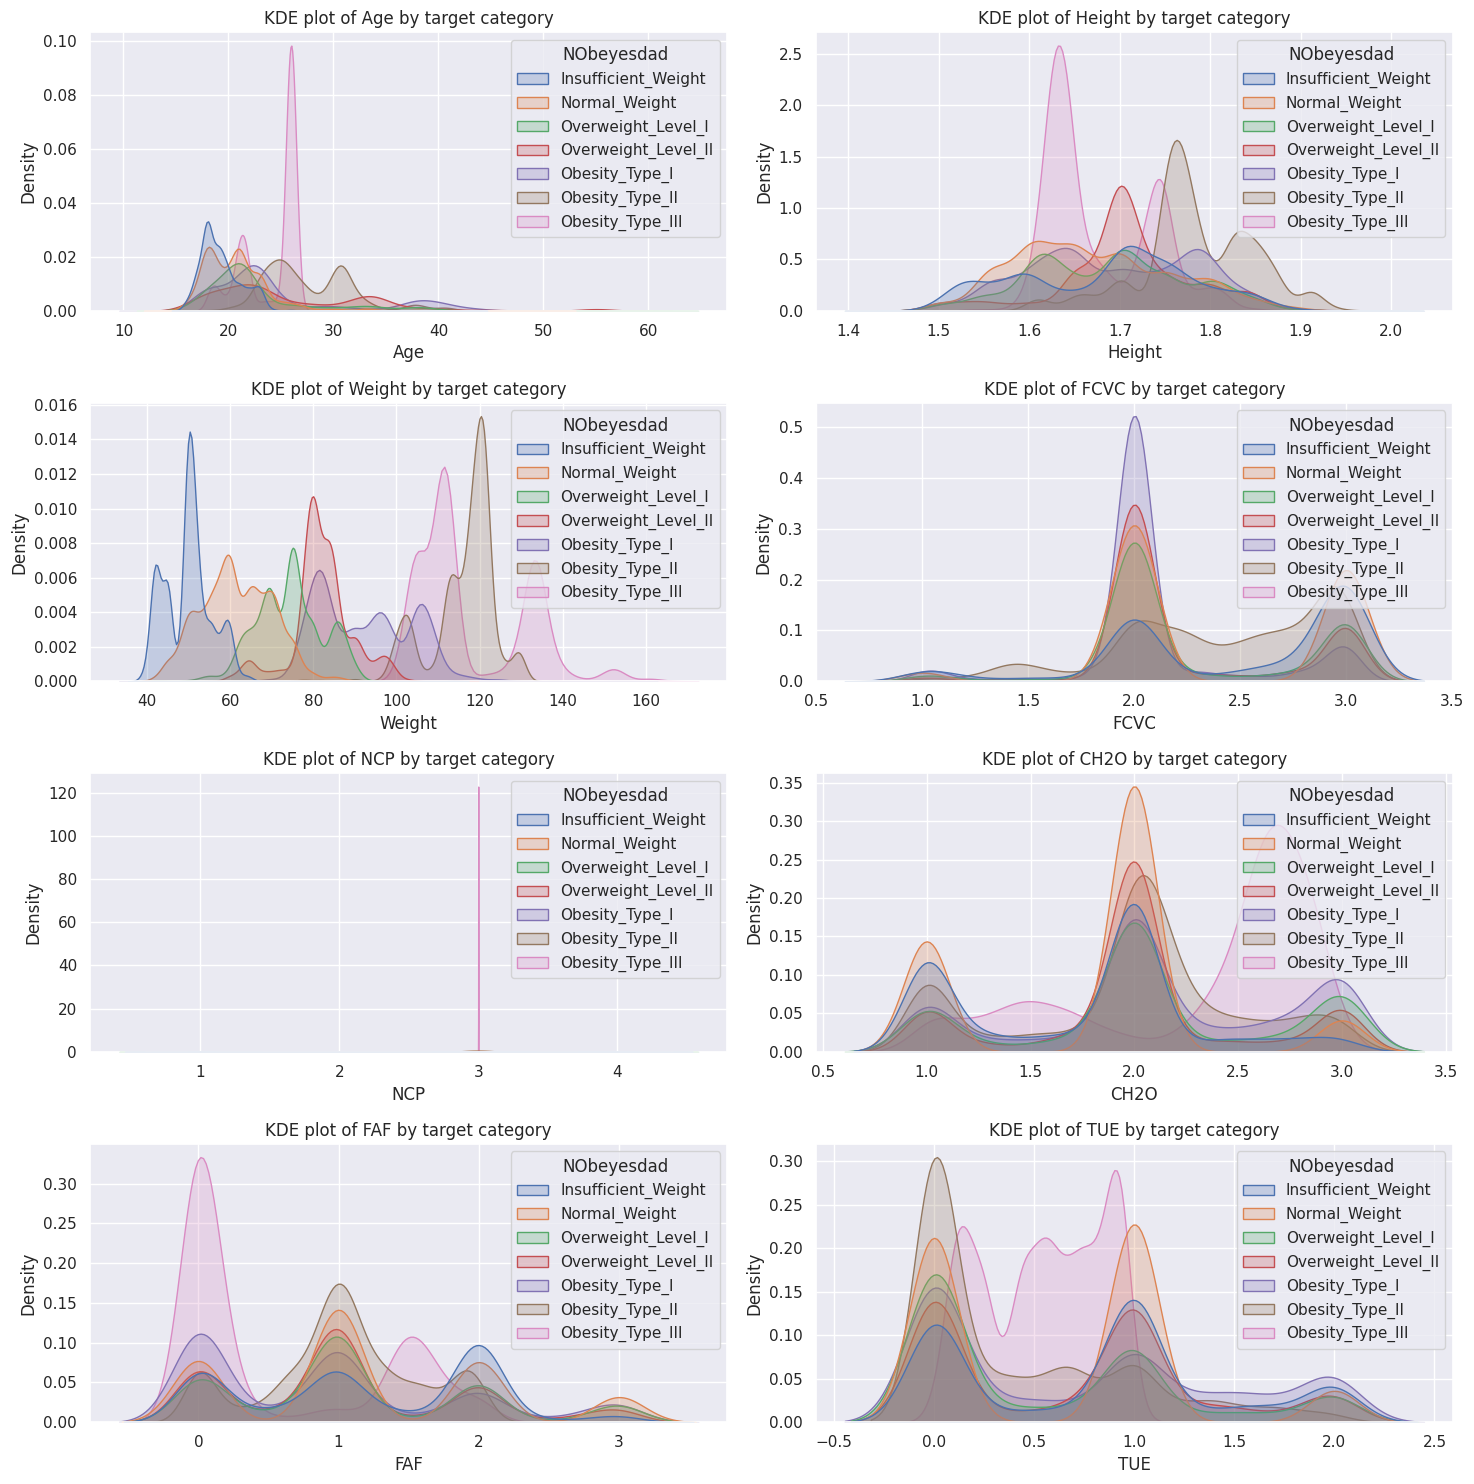

In [26]:
num_cols = len(train_df[num_features].columns)

ncols = 2
nrows = math.ceil(num_cols / ncols) # determine number of rows for subplots

# Set plot size and create a grid of subplots.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for i, col in enumerate(train_df[num_features].columns):
    # Assign subplot to grid spaces.
    row_idx = i // ncols
    col_idx = i % ncols
    
    ax =  sns.kdeplot(data=train_df, x=train_df[col], hue='NObeyesdad', hue_order=target_order, ax=axes[row_idx, col_idx], fill=True)
    ax.set(title=f"KDE plot of {col} by target category")

plt.tight_layout()
plt.show()

Insight from numerical feature KDE plots by target category:
- Weight and Height show noticably different distributions for each target category - these features will likely be important for modelling.
- NCP - Meals per day barely varies by target category - unlikely useful and candidate for dropping.
- FAF- Most obese distribution centered around low physical activity - makes intuitive sense.
- Age - There is a spike of
- CH20 - Curiously, most obese seem to drink a lot of water - not sure how to explain this yet. 

#### Categorical features by target category:

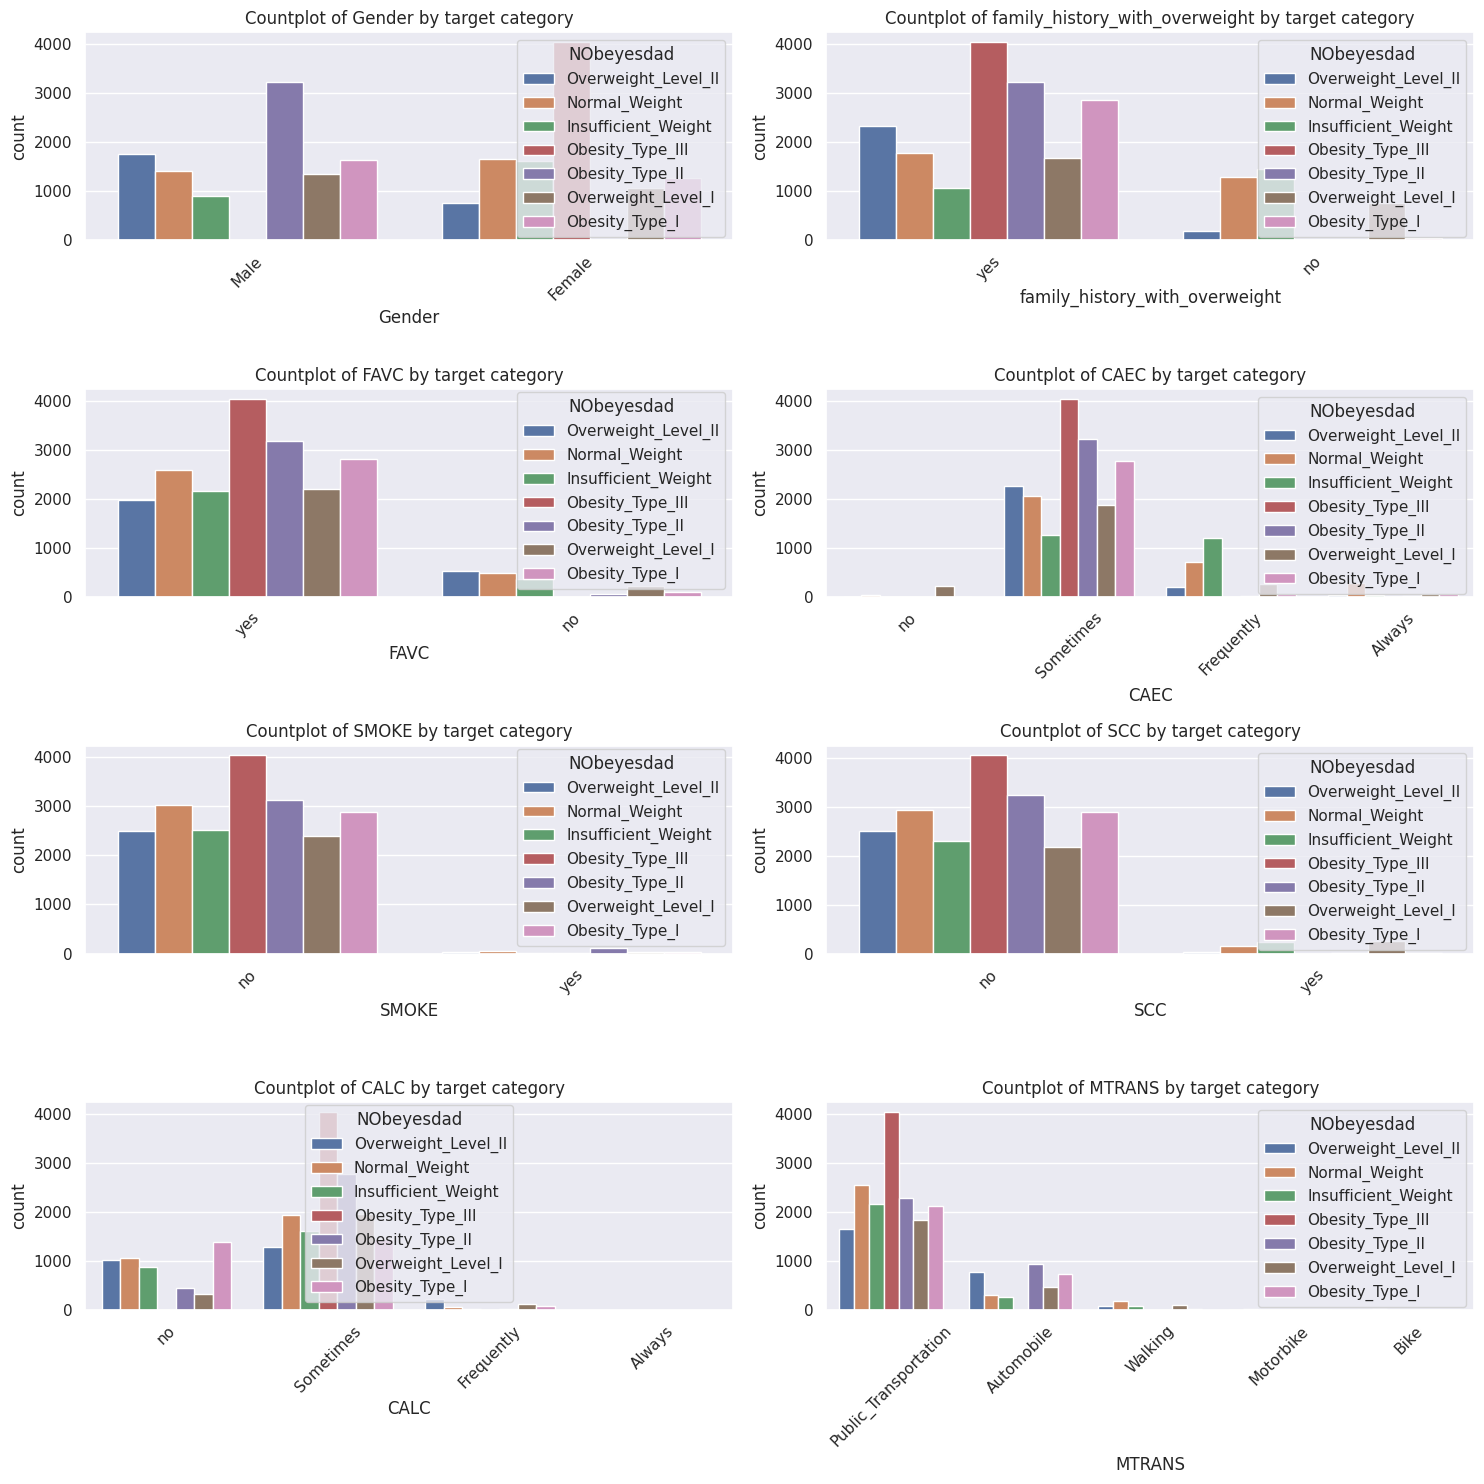

In [27]:
num_cols = len(train_df[cat_features].columns)

ncols = 2
nrows = math.ceil(num_cols / ncols) # determine number of rows for subplots

# Set plot size and create a grid of subplots.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for i, col in enumerate(train_df[cat_features].columns):
    # Assign subplot to grid spaces.
    row_idx = i // ncols
    col_idx = i % ncols

    # Set order when categories are more than 2,
    if col in ['CAEC', 'CALC']:
        order=['no', 'Sometimes', 'Frequently', 'Always']
    else:
        order=None

    ax = sns.countplot(x=col, data=train_df, ax=axes[row_idx, col_idx], hue='NObeyesdad', order=order)
    ax.set(title=f"Countplot of {col} by target category")

    # Rotate x-axis labels and tick parameters for better readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

💡 Insight from countplots of categorical variables by target category:
- No major differences between the target categories when it comes to categorical features.

<a id = "comp-original"></a>
### Exploring the competition training set versus the original dataset

How similar is the competition dataset to the original dataset? If they are similar, then it will likely make sense to train our models on the combined dataset, since more training data is one of the best ways to improve a model's performance.

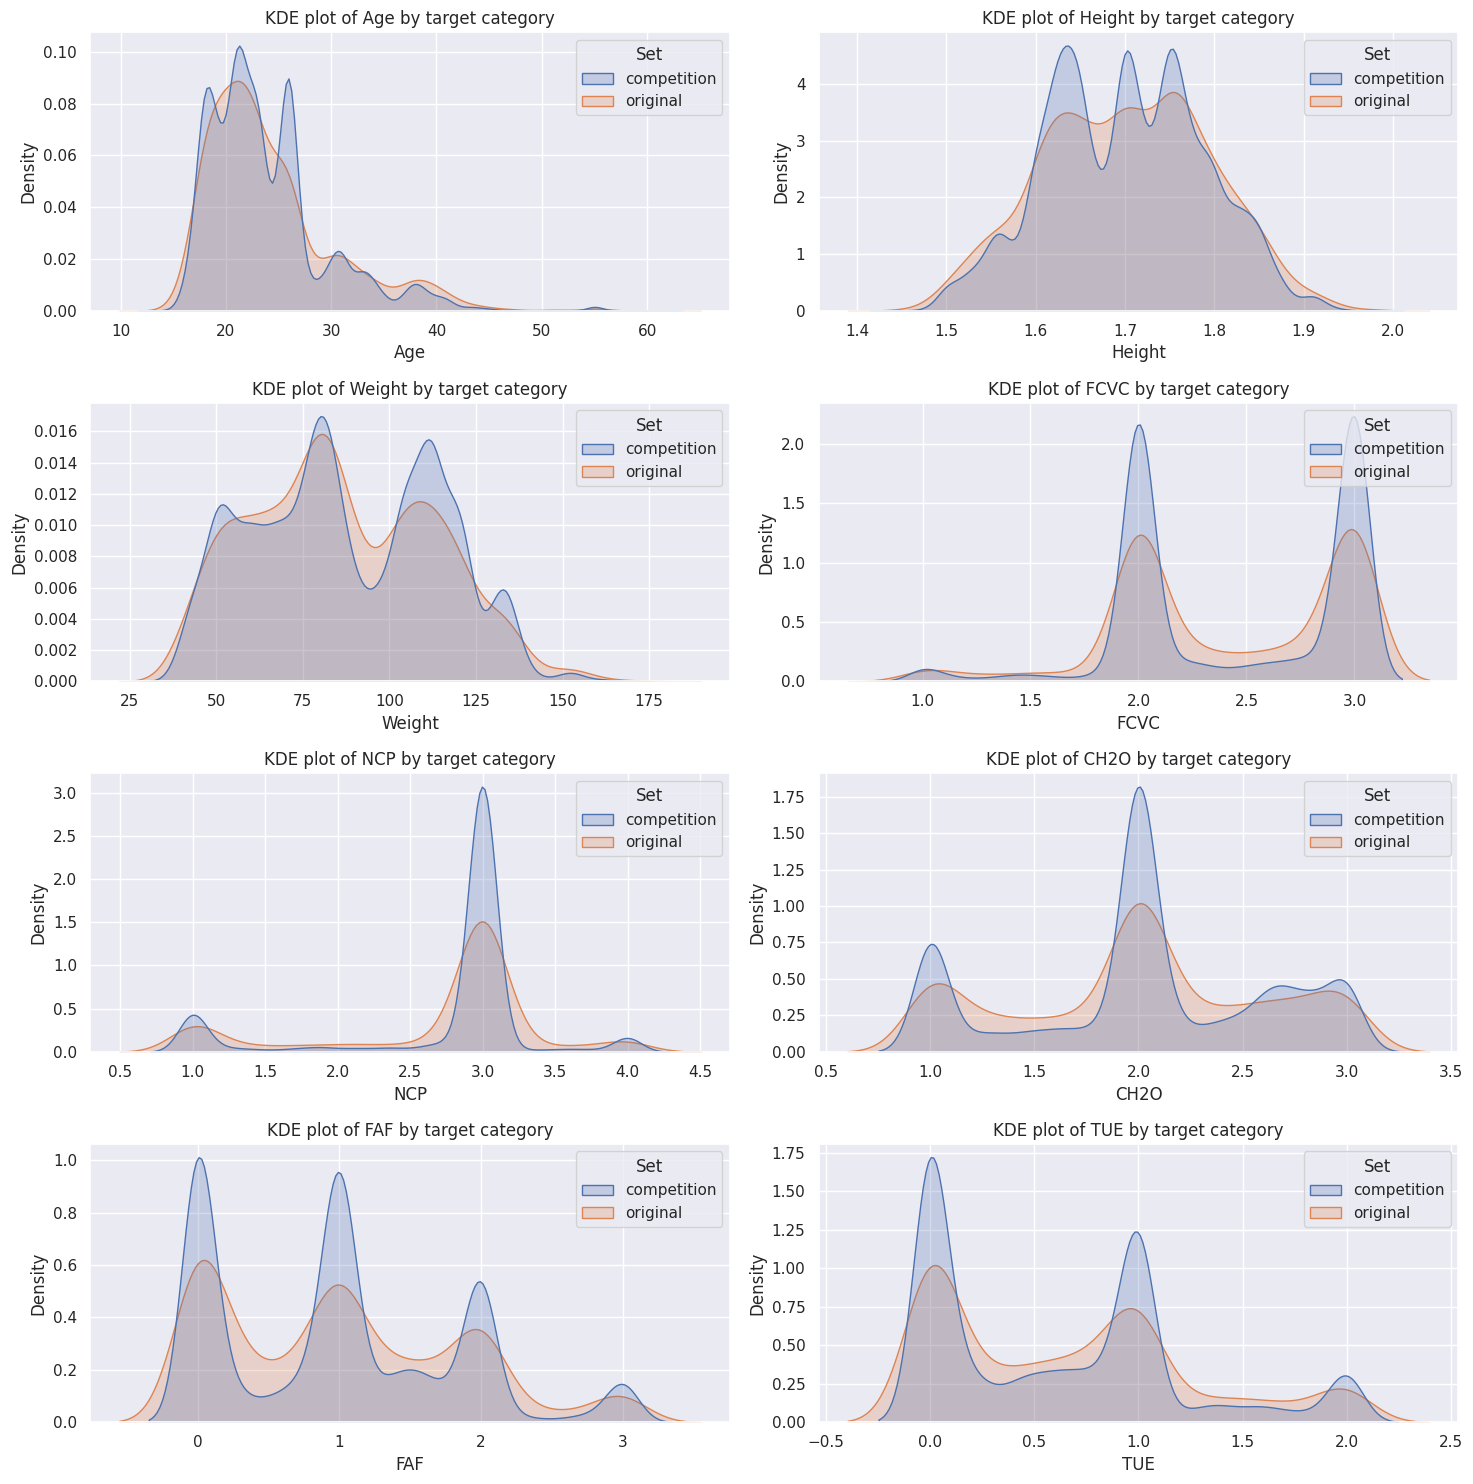

In [28]:
num_cols = len(train_combined_df[num_features].columns)

ncols = 2
nrows = math.ceil(num_cols / ncols) # determine number of rows for subplots

# Set plot size and create a grid of subplots.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for i, col in enumerate(train_combined_df[num_features].columns):
    # Assign subplot to grid spaces.
    row_idx = i // ncols
    col_idx = i % ncols
    
    ax =  sns.kdeplot(data=train_combined_df, x=train_combined_df[col], hue='Set', common_norm=False, ax=axes[row_idx, col_idx], fill=True)
    ax.set(title=f"KDE plot of {col} by target category")

plt.tight_layout()
plt.show()


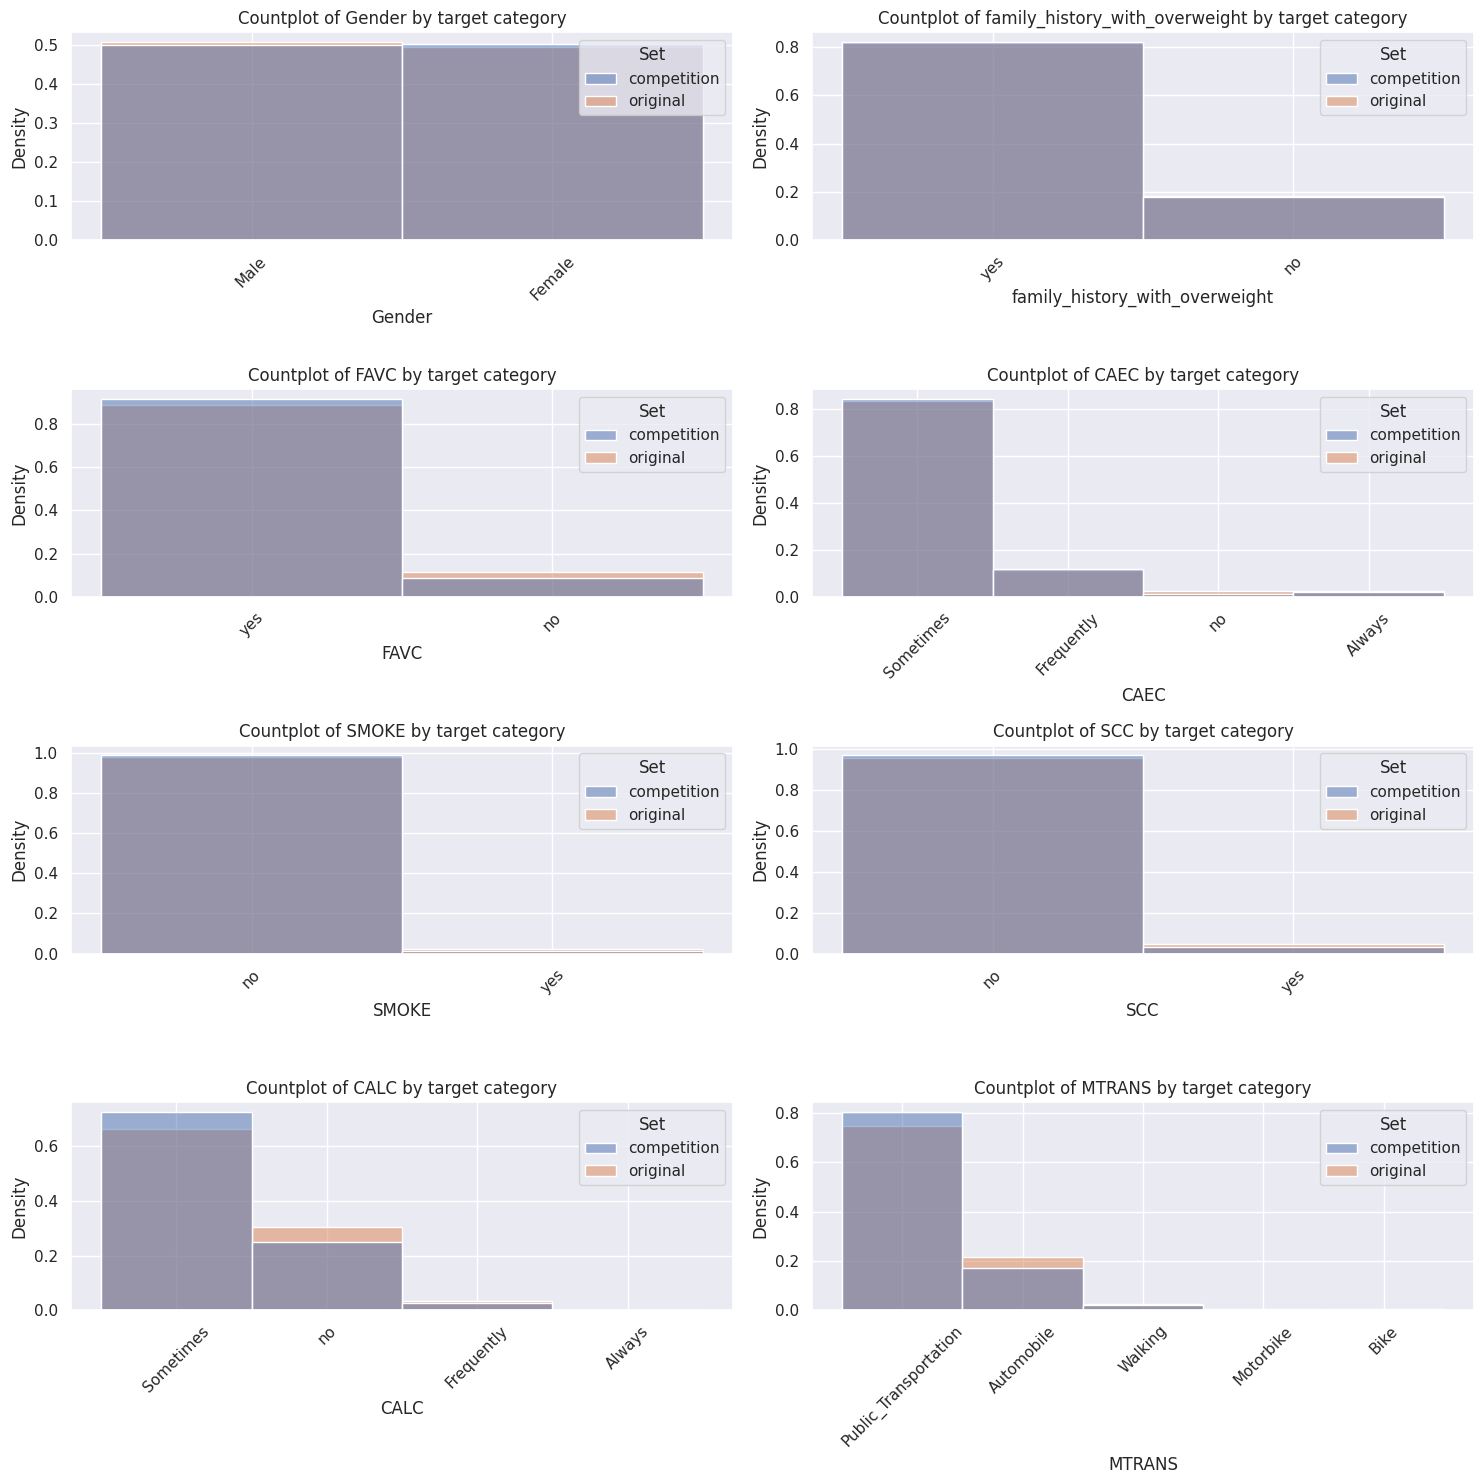

In [29]:
num_cols = len(train_combined_df[cat_features].columns)

ncols = 2
nrows = math.ceil(num_cols / ncols) # determine number of rows for subplots

# Set plot size and create a grid of subplots.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

for i, col in enumerate(train_combined_df[cat_features].columns):
    # Assign subplot to grid spaces.
    row_idx = i // ncols
    col_idx = i % ncols

    # Set order when categories are more than 2,
    if col in ['CAEC', 'CALC']:
        order=['no', 'Sometimes', 'Frequently', 'Always']
    else:
        order=None

    ax = sns.histplot(x=col, data=train_combined_df, ax=axes[row_idx, col_idx], hue='Set', stat='density', common_norm=False)
    ax.set(title=f"Countplot of {col} by target category")

    # Rotate x-axis labels and tick parameters for better readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Insight from training vs original dataset comparison.
- Numerical features: smoother in the original dataset, but similar.
- Categorical features: very similar.
- It will like make sense to train our models on the combined dataset.

<a id = "pre-processing"></a>
# Pre-processing

<a id = "missing"></a>
### Missing data

In [30]:
X_train_raw.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

In [31]:
X_train_comb.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

In [32]:
X_test_raw.isnull().sum()

Gender                            13840
Age                                   0
Height                                0
Weight                                0
family_history_with_overweight    13840
FAVC                              13840
FCVC                                  0
NCP                                   0
CAEC                              13840
SMOKE                             13840
CH2O                                  0
SCC                               13840
FAF                                   0
TUE                                   0
CALC                              13840
MTRANS                            13840
dtype: int64

In [33]:
y_train_raw.isnull().sum()

0

There are no missing values

<a id = "encode-target"></a>
### Encoding target labels

In [34]:
# Use Label encoder to create encoded and decoded target variables.
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_raw)
y_train_decoded = le.inverse_transform(y_train_encoded)
y_train_encoded.shape

(20758,)

In [35]:
# Use Label encoder to create encoded and decoded target variables for the combined dataset.
le = LabelEncoder()
y_train_comb_enc = le.fit_transform(y_train_comb)
y_train_comb_dec = le.inverse_transform(y_train_comb_enc)
y_train_comb_enc.shape

(22869,)

In [36]:
num_classes = len(np.unique(y_train_encoded)) # there are 7 classes. We'll need this as a hyperparameter for our models.

In [37]:
# Double check encoding wored as expected.
print(le.inverse_transform(y_train_encoded[:5]))
print(y_train_raw[:5].to_list())

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Overweight_Level_II']
['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight', 'Obesity_Type_III', 'Overweight_Level_II']


<a id = "encode-cats"></a>
### Encoding category features

From the categorical charts above in the EDA, we can see that CALC and CAEC have the same ordinal categories. We'll create a custom FunctionTransformer so that we can apply a mapping to these columns and then build a pipeline to process the other columns too.

In [38]:
freq_mapping = {
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3,
}
inverse_freq_mapping = {v: k for k,v in freq_mapping.items()}

In [39]:
# Define a custom transformer to apply the frequency mapping.
def frequency_encoder(df):
    for col in df.columns:
        df[col] = df[col].map(freq_mapping)
    return df
freq_encoder = FunctionTransformer(frequency_encoder, feature_names_out='one-to-one')

In [40]:
# Define a one hot encoder for the binary columns
one_hot_enc = OneHotEncoder(categories='auto', drop='first')

In [41]:
# Create a column transformer
col_trans = ColumnTransformer(
    transformers=[
        ('ordinal', freq_encoder, freq_features),
        ('onehot', one_hot_enc, binary_features)
    ],
    remainder='passthrough',
)

In [42]:
# Create a pipeline with the column transformer
pipeline = Pipeline([
    ('transform_cols', col_trans),
],
memory="./cache" # Add a cache to save on computations
)

In [43]:
pipeline.fit_transform(X_train_raw).shape

(20758, 19)

<a id = "importances"></a>
### Feature importances

Now that we've encoded all features into numbers, we can pass the training dataset through a Random Forest Classifier to get an initial view of feature importance.

In [44]:
feature_labels_encoded = pipeline.get_feature_names_out()
feature_labels_encoded

array(['ordinal__CAEC', 'ordinal__CALC', 'onehot__Gender_Male',
       'onehot__family_history_with_overweight_yes', 'onehot__FAVC_yes',
       'onehot__SMOKE_yes', 'onehot__SCC_yes', 'onehot__MTRANS_Bike',
       'onehot__MTRANS_Motorbike', 'onehot__MTRANS_Public_Transportation',
       'onehot__MTRANS_Walking', 'remainder__Age', 'remainder__Height',
       'remainder__Weight', 'remainder__FCVC', 'remainder__NCP',
       'remainder__CH2O', 'remainder__FAF', 'remainder__TUE'],
      dtype=object)

In [45]:
# Create a Random Forest Classifier and fit to training data.
rf = RandomForestClassifier()
pipe_rf = Pipeline([
    ('transform_cols', col_trans),
    ('rf', rf)
    ],
    memory="./cache"
)
pipe_rf.fit(X=X_train_raw, y=y_train_encoded)

Pipeline(memory='./cache',
         steps=[('transform_cols',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function frequency_encoder at 0x795c64a60e50>),
                                                  ['CAEC', 'CALC']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS'])])),
                ('rf', RandomForestClassifier())])

In [46]:
feature_importances = pipe_rf[-1].feature_importances_ # index [-1] to acces the Random Forest within the pipeline.

In [47]:
indices = np.argsort(feature_importances) # Get indexes of feature importances in ascending order.

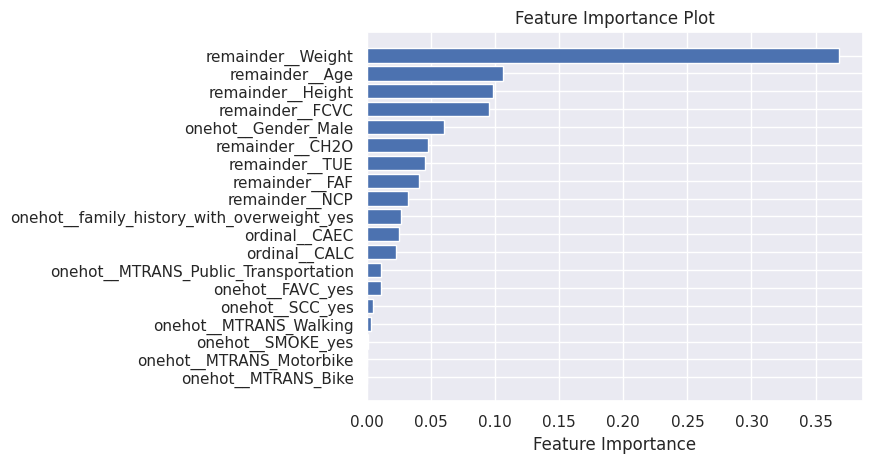

In [49]:
# Create a bar plot for feature importance
plt.barh(range(len(feature_importances)), feature_importances[indices], align="center")
plt.yticks(range(len(feature_importances)), feature_labels_encoded[indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.show()

Insight from feature importance plot:
- Weight is the overwhelmingly important feature when it comes to determining obesity risk, followed by age, weight, and frequency of eating vegetables.
- Mode of transport seemingly has little affect, as does smoking.

<a id = "modelling"></a>
# Modelling

<a id = "xgb"></a>
### XGBoost

Now we're ready to try some different models. Let's start with XGBoost because it's often highly successful with tabular data.

In [50]:
xgb = XGBClassifier(objective='multi:softmax', num_class=num_classes, n_jobs=-1, seed=0,)

# Use column transformer to encode categorical features and normalize the numerical features.
col_trans_xgb = ColumnTransformer(
    transformers=[
        ('ordinal', freq_encoder, freq_features),
        ('onehot', one_hot_enc, binary_features),
        ('normalize', StandardScaler(), num_features)
    ],
    remainder='passthrough',
)

# Define pipeline with xgb classifier.
pipe_xgb = Pipeline([
    ('transform_cols', col_trans_xgb),
    ('xgb', xgb),
])

In [51]:
# Define distributions to search over hyprparameters.
xgb_grid = {
    'xgb__n_estimators': randint(200,1000), # number of trees
    'xgb__learning_rate': loguniform(1e-2,1e0), # learning rate controls the weight applied to each new tree.
    'xgb__max_depth': randint(4,10), # maximum depth of each tree.
    'xgb__min_split_loss': uniform(loc=0.0,scale=1.0), # Minimum loss needed for a split to take place.
    'xgb__subsample': uniform(loc=0.6,scale=0.4), # proportion of samples randomly selected for each tree
    'xgb__colsample_bytree': uniform(loc=0.6,scale=0.4), # proportion of features randomly select for each tree.
    'xgb__reg_lambda': uniform(loc=1.0,scale=20.0), # L2 regularization term (i.e. makes model more conservative and helps reduce overfitting.)
}

In [52]:
rs_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=xgb_grid,
    n_iter=5,  # Number of random combinations to try
    scoring='accuracy', # Scoring metric.
    n_jobs=-1,  # Use all available CPU cores
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Show more information during the search
    random_state=23 # Set seed for reproducability.
)

In [53]:
rs_xgb.fit(X_train_comb, y_train_comb_enc)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transform_cols',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinal',
                                                                               FunctionTransformer(feature_names_out='one-to-one',
                                                                                                   func=<function frequency_encoder at 0x795c64a60e50>),
                                                                               ['CAEC',
                                                                                'CALC']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Gender',
                                                                                'family_history_with_overweight',
                                                                                'FAVC',
                                                                                'SMOKE',
                                                                                '...
                                        'xgb__min_split_loss': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x795c64baf820>,
                                        'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x795c64aab5b0>,
                                        'xgb__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x795c65115900>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x795c905045e0>},
                   random_state=23, scoring='accuracy', verbose=1)

In [54]:
rs_xgb.best_params_

{'xgb__colsample_bytree': 0.6399280470384433,
 'xgb__learning_rate': 0.027498261660190936,
 'xgb__max_depth': 8,
 'xgb__min_split_loss': 0.411930094858746,
 'xgb__n_estimators': 659,
 'xgb__reg_lambda': 16.091457200651195,
 'xgb__subsample': 0.9987462248949633}

In [55]:
rs_xgb.best_score_

0.9133770479012618

In [57]:
# Best parameters found using Randomized search (doesn't match above because I copied these from a previous run, before I set the random seed).
best_xgb_params = {'colsample_bytree': 0.606226665860026,
 'learning_rate': 0.14059228664042647,
 'max_depth': 8,
 'min_split_loss': 0.6877017445280331,
 'n_estimators': 917,
 'reg_lambda': 6.637583798291585,
 'subsample': 0.824970683580847}

In [58]:
# We can verify that the above parameters are best by passing best params and cross validating.
xgb = XGBClassifier(objective='multi:softmax', num_class=num_classes, n_jobs=-1, seed=0,**best_xgb_params)

col_trans_xgb = ColumnTransformer(
    transformers=[
        ('ordinal', freq_encoder, freq_features),
        ('onehot', one_hot_enc, binary_features),
        ('normalize', StandardScaler(), num_features)
    ],
    remainder='passthrough',
)

# Define pipeline with xgb classifier and best params.
best_xgb = Pipeline([
    ('transform_cols', col_trans_xgb),
    ('xgb', xgb),
    ],
)

In [60]:
cv_dict= cross_validate(estimator=best_xgb, X=X_train_comb, y=y_train_comb_enc, scoring='accuracy', return_train_score=True,  cv=5, n_jobs=-1)
cv_dict

{'fit_time': array([23.68007851, 24.18427753, 24.16504955, 24.23023129, 17.31912994]),
 'score_time': array([0.32149386, 0.28706717, 0.29338241, 0.29019523, 0.18209076]),
 'test_score': array([0.90664626, 0.90795802, 0.91429821, 0.90905116, 0.9330855 ]),
 'train_score': array([0.95304728, 0.95512435, 0.9528833 , 0.95392184, 0.94955181])}

In [61]:
print('Avg. train score', np.mean(cv_dict['train_score']))
print('Avg. test score', np.mean(cv_dict['test_score']))
print('train - test', (np.mean(cv_dict['train_score'] - cv_dict['test_score'])))

Avg. train score 0.9529057168426937
Avg. test score 0.9142078305860017
train - test 0.038697886256691884


This XGB model alone is already showing good performance. But combining models into an ensemble can sometime help increase the performance when submitting, since the models help address eachother's weaknesses. So let's train a few more.

<a id = "import"></a>
### CatBoost

In [62]:
cb = CatBoostClassifier(cat_features=cat_features, bootstrap_type='Bernoulli')

In [63]:
cb_grid = {
    'learning_rate': loguniform(1e-2, 1e0), # learning rate controls the weight applied to each new tree.
    'iterations': randint(150, 1000), # number of trees
    'depth': randint(4,10), # maximum depth of each tree.
    'l2_leaf_reg': uniform(loc=1.0,scale=15.0), # L2 regularization term (i.e. makes model more conservative and helps reduce overfitting.)
    'subsample': uniform(loc=0.6,scale=0.4), # proportion of samples randomly selected for each tree
}

In [64]:
rs_cb = RandomizedSearchCV(
    cb, # passing the model directly since catboost can handle the training data in unprocessed form.
    param_distributions=cb_grid,
    n_iter=10,  # Number of random combinations to try
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    cv=5,  # 5-fold cross-validation
    verbose=0,  # Show more information during the search
    random_state=23
)

In [ ]:
rs_cb.fit(X_train_comb, y_train_comb_enc)

```
{'fit_time': array([3.95321512, 3.984483  , 3.90473294, 3.94676518, 3.95245218]),
 'score_time': array([0.14075899, 0.139678  , 0.13831234, 0.14078093, 0.128582  ]),
 'test_score': array([0.90577175, 0.90883253, 0.91364233, 0.90970704, 0.93527225]),
 'train_score': array([0.9542498 , 0.95463241, 0.95337524, 0.95414048, 0.94966113])}
 ```
   **copied output for display purposese*

In [ ]:
rs_cb.best_params_

```
{'depth': 7,
 'iterations': 567,
 'l2_leaf_reg': 1.9761315858579023,
 'learning_rate': 0.03885875923734728,
 'subsample': 0.7151737763868986}
```
 **copied output for display purposese*

In [ ]:
rs_cb.best_score_
#0.9097040278718138

In [ ]:
best_cb = rs_cb.best_estimator_

In [ ]:
cv_dict= cross_validate(estimator=best_cb, X=X_train_comb, y=y_train_comb_enc, scoring='accuracy', return_train_score=True,  cv=5, n_jobs=-1)
cv_dict

```
{'fit_time': array([86.18757701, 86.30894709, 86.84165812, 88.01140404, 89.55027699]),
 'score_time': array([0.04186797, 0.02549601, 0.023103  , 0.04081631, 0.00567722]),
 'test_score': array([0.90467862, 0.9005247 , 0.90730214, 0.90489725, 0.93111743]),
 'train_score': array([0.93189396, 0.93451763, 0.92981689, 0.93189396, 0.92430039])}
```
**copied output for display purposes.*

In [ ]:
print('Avg. train score', np.mean(cv_dict['train_score']))
print('Avg. test score', np.mean(cv_dict['test_score']))
print('train - test', (np.mean(cv_dict['train_score'] - cv_dict['test_score'])))


```
Avg. train score 0.9304845662706365
Avg. test score 0.9097040278718138
train - test 0.020780538398822566
```
 **copied output for display purposese*

Performance of CatBoost, based on this hyperparameter search, is not as good as the XGB classifer.

<a id = "lgbm"></a>
### LightGBM

For the LGBM hyperparameters, I took initial inspiration from [this great notebook](https://www.kaggle.com/code/divyam6969/easy-beginner-friendly-92-accuracy#LGBM-Model). However, I removed the `max_depth` parameter and instead tuned using `num_leaves`, which is recommended in the [documentation](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html#tune-parameters-for-the-leaf-wise-best-first-tree) given LightGBM is a leaf-wise (rather than depth-wise) algorithm.

I ran a few cross validations just tweaking down the `num_leaves` parameter and settled on 20. It gave pretty goood performance and faster training time.

In [66]:
best_lgbm_params = {
    'learning_rate': 0.031,
    'n_estimators': 500,
    'lambda_l1': 0.01,
    'lambda_l2': 0.04,
    'num_leaves': 20, # hand tuned this down to 20.
    'colsample_bytree': 0.4,
    'subsample': 0.95,
    'min_child_samples': 26,   
}

In [67]:
lgbm = LGBMClassifier(objective= 'multiclass',
                    metric='multi_logloss',
                    num_class=num_classes, 
                    boosting_type='gbdt', 
                    class_weight='balanced', 
                    verbosity=-1,
                    random_state=42,
                    **best_lgbm_params)

col_trans_lgbm = ColumnTransformer(
    transformers=[
        ('ordinal', freq_encoder, freq_features),
        ('onehot', one_hot_enc, binary_features),
        ('normalize', StandardScaler(), num_features)
    ],
    remainder='passthrough',
)

# Uses same pipeline as XGB.
pipe_lgbm = Pipeline([
    ('transform_cols', col_trans_lgbm),
    ('lgbm', lgbm),
    ],
)

In [ ]:
cv_dict= cross_validate(estimator=pipe_lgbm, X=X_train_comb, y=y_train_comb_enc, scoring='accuracy', return_train_score=True,  cv=5, n_jobs=-1)
cv_dict

```
{'fit_time': array([60.69047713, 60.94693089, 60.44615102, 61.46330905, 60.36264801]),
 'score_time': array([0.561589  , 0.95838094, 0.47175884, 1.10066199, 0.47170496]),
 'test_score': array([0.9086139 , 0.90817665, 0.91211194, 0.91211194, 0.93199213]),
 'train_score': array([0.96693086, 0.96824269, 0.96753211, 0.96802405, 0.96283341])}
```
 **copied output for display purposese*

In [ ]:
print('Avg. train score', np.mean(cv_dict['train_score']))
print('Avg. test score', np.mean(cv_dict['test_score']))
print('train - test', (np.mean(cv_dict['train_score'] - cv_dict['test_score'])))

```
Avg. train score 0.9667126227558764
Avg. test score 0.9146013114179146
train - test 0.05211131133796183
```
 **copied output for display purposese*

In [69]:
lgbm_grid = {
    'lgbm__learning_rate': loguniform(1e-2, 1e-1), # learning rate controls the weight applied to each new tree.
    'lgbm__n_estimators': randint(500,1000), # number of trees
    'lgbm__lambda_l2': uniform(loc=0.0,scale=5.0), # L2 regularization term (i.e. makes model more conservative and helps reduce overfitting.)
    'lgbm__num_leaves': randint(15,20), # max leaves per tree.
    'lgbm__colsample_bytree': uniform(loc=0.5,scale=0.5), # proportion of features randomly select for each tree.
    'lgbm___min_child_samples': randint(5,30), # must have at least this many samples in a child.
    'lgbm__subsample': uniform(loc=0.6,scale=0.4), # proportion of samples randomly selected for each tree
}

In [70]:
rs_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_distributions=lgbm_grid,
    n_iter=10,  # Number of random combinations to try
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Show more information during the search
)

In [ ]:
rs_lgbm.fit(X_train_comb, y_train_comb_enc)

In [ ]:
rs_lgbm.best_params_

```
{'lgbm___min_child_samples': 9,
 'lgbm__colsample_bytree': 0.7422689371518487,
 'lgbm__lambda_l2': 1.611131098788226,
 'lgbm__learning_rate': 0.016824540900298068,
 'lgbm__n_estimators': 963,
 'lgbm__num_leaves': 18,
 'lgbm__subsample': 0.9484738305328333}
 ```
 **copied output for display purposese*

In [ ]:
rs_lgbm.best_score_
# 0.9132458430029458

After trying a further hyperparamter tuning via random search, the performance of the LightGBM did not improve versus what we started with. We'll take that earlier classifier forward into the ensemble with a voting classifier.

<a id = "vote"></a>
### Voting Classifier

The voting classifer allows us to combine multiple models and choose the relative weight we would like to apply to each. The XGB and LightGBM classifers both trained with good performance. So we'll combine these and leave our the CatBoost for now.

In [71]:
from sklearn.ensemble import VotingClassifier
voter1 = VotingClassifier(
    estimators=[('xgb', pipe_xgb), ('lgbm', pipe_lgbm)],
    voting='soft',
    weights=[1,1]
    )

In [ ]:
cv_dict= cross_validate(estimator=voter1, X=X_train_raw, y=y_train_encoded, scoring='accuracy', return_train_score=True,  cv=5, n_jobs=-1)
cv_dict

```
{'fit_time': array([71.13491082, 73.61463189, 70.01915503, 70.99218702, 72.885041  ]),
 'score_time': array([0.56475019, 0.48441505, 0.38239002, 0.70633602, 0.47309613]),
 'test_score': array([0.90582852, 0.90342004, 0.91353565, 0.90941942, 0.91399663]),
 'train_score': array([0.97783934, 0.97850175, 0.97958569, 0.98049015, 0.979888  ])}
 ```
  **copied output for display purposese*

In [ ]:
print('Avg. train score', np.mean(cv_dict['train_score']))
print('Avg. test score', np.mean(cv_dict['test_score']))
print('train - test', (np.mean(cv_dict['train_score'] - cv_dict['test_score'])))

```
Avg. train score 0.9792609854491895
Avg. test score 0.9092400489424047
train - test 0.07002093650678462
```
 **copied output for display purposese*

The combined performance does not seem as good as the individual models. However, still worth a submission to see how it performs on the leaderboard.

<a id = "pred"></a>
# Predictions

<a id = "final"></a>
### Final pre-processing pipeline

We'll submit the voting classifier.

In [73]:
best_model = voter1

First fit the best model to the combined training and ordiginal data.

In [74]:
best_model.fit(X_train_comb, y_train_comb_enc)

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('transform_cols',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('ordinal',
                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                    func=<function frequency_encoder at 0x795c64a60e50>),
                                                                                ['CAEC',
                                                                                 'CALC']),
                                                                               ('onehot',
                                                                                OneHotEncoder(drop='first'),
                                                                                ['Gender',
                                                                                 'family_history_with_overweight',
                                                                                 'FAVC',
                                                                                 'SMOKE'...
                                                                                 'Weight',
                                                                                 'FCVC',
                                                                                 'NCP',
                                                                                 'CH2O',
                                                                                 'FAF',
                                                                                 'TUE'])])),
                                              ('lgbm',
                                               LGBMClassifier(class_weight='balanced',
                                                              colsample_bytree=0.4,
                                                              lambda_l1=0.01,
                                                              lambda_l2=0.04,
                                                              learning_rate=0.031,
                                                              metric='multi_logloss',
                                                              min_child_samples=26,
                                                              n_estimators=500,
                                                              num_class=7,
                                                              num_leaves=20,
                                                              objective='multiclass',
                                                              random_state=42,
                                                              subsample=0.95,
                                                              verbosity=-1))]))],
                 voting='soft', weights=[1, 1])

<a id = "test"></a>
### Predictions on test set

Get predictions on the test set.

In [ ]:
y_pred = best_model.predict(X_test_raw)
y_pred

In [ ]:
y_pred_decoded = le.inverse_transform(y_pred)
y_pred_decoded

In [ ]:
y_pred_decoded.shape

<a id = "import"></a>
# Submission

In [ ]:
subm = pd.read_csv('data/sample_submission.csv', index_col='id')
subm.head()

In [ ]:
subm.shape

In [ ]:
subm['NObeyesdad'] = y_pred_decoded
subm.head()

**Well done if you have made it this far! If you have found the notebook helpful, please upvote it so that it's easier for others to find. Thank you! 🙏**